# ***Restaurant Reviews***

In this we will predicted whether the comment or review given by the user to the particular restaurant is good or bad.

consisting 1000 samples of the reviews with thier particular labels


*   Target 0 : Bad
*   Target 1 : Good



### Importing libraries and getting data ready

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
resturant_review = pd.read_csv('/content/drive/MyDrive/data/Resturant_Reviews/archive(1)/Restaurant_Reviews.csv')
resturant_review.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
resturant_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


### Preprocessing the data and visualize 

In [4]:
#checking for the null values
resturant_review.isna().sum()

Review    0
Liked     0
dtype: int64

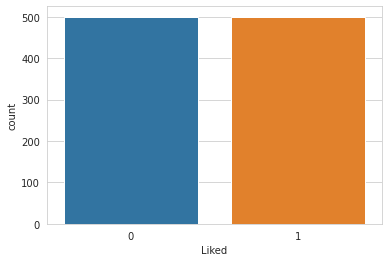

In [5]:
sns.set_style('whitegrid')
sns.countplot(data=resturant_review,x='Liked')

In [6]:
# calculating number of words in the sequence

total_words =[]
for i in resturant_review['Review']:
  a = i.split(' ')
  total_words.append(len(a))
  

In [7]:
resturant_review['total_words'] = total_words
resturant_review.head()

,Review,Liked,total_words
0,Wow... Loved this place.,1,4
1,Crust is not good.,0,4
2,Not tasty and the texture was just nasty.,0,8
3,Stopped by during the late May bank holiday of...,1,15
4,The selection on the menu was great and so wer...,1,12


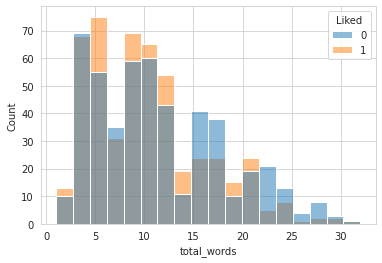

In [8]:
sns.histplot(data=resturant_review,x='total_words',hue='Liked')

In [9]:
# length of the sequence
length_sequence = []
for i in resturant_review['Review']:
  a = list(i)
  length_sequence.append(len(a))

length_sequence[:5]

[24, 18, 41, 87, 59]

In [10]:
resturant_review['length_sequence'] = length_sequence
resturant_review.head()

,Review,Liked,total_words,length_sequence
0,Wow... Loved this place.,1,4,24
1,Crust is not good.,0,4,18
2,Not tasty and the texture was just nasty.,0,8,41
3,Stopped by during the late May bank holiday of...,1,15,87
4,The selection on the menu was great and so wer...,1,12,59


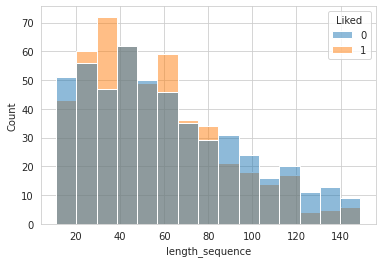

In [11]:
sns.histplot(data=resturant_review,x='length_sequence',hue='Liked')

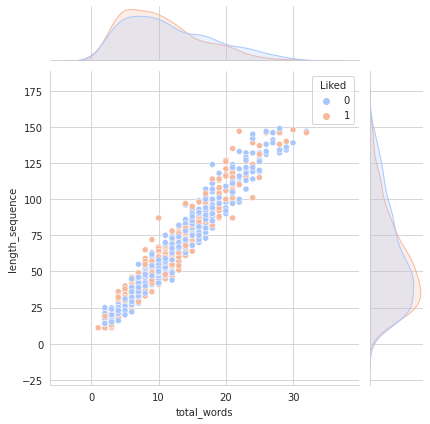

In [12]:
sns.jointplot(data=resturant_review,x='total_words',y='length_sequence',hue='Liked',palette='coolwarm')

### Spliting data into train and test data sets

In [13]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(resturant_review['Review'],resturant_review['Liked'],test_size=0.2,random_state=42)

x_train.shape,y_train.shape,x_test.shape,y_test.shape

((800,), (800,), (200,), (200,))

In [14]:
pd.DataFrame(y_test).value_counts()

Liked
1        104
0         96
dtype: int64

In [15]:
# creating a random sample
import random
i = random.randint(0,1000)
print('Target:'+str(resturant_review['Liked'][i]))
print(resturant_review['Review'][i])

Target:1
This is an Outstanding little restaurant with some of the Best Food I have ever tasted.


### Converting Text into numbers using


1.   Text Vectorization
2.   Embeddings



In [16]:
# text vectorization
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [17]:
# getting the vocab size
a = []
for i in resturant_review['Review']:
  review = i.split()
  for j in review:
    a.append(j)

In [18]:
len(set(a)) # length of the diiferent words use in the reviews the size of the vocab

2967

In [19]:
# getting the size of the output token
np.percentile(total_words,95)

23.0

In [20]:
text_vectorizer = TextVectorization(max_tokens=3100,output_sequence_length=25)
text_vectorizer.adapt(x_train)

In [21]:
vocab=text_vectorizer.get_vocabulary()
print('highest 5 words')
print(vocab[:5])
print('lowest 5 words')
print(vocab[-5:])

highest 5 words
['', '[UNK]', 'the', 'and', 'i']
lowest 5 words
['17', '15lb', '12', '100', '1']


In [22]:
# creating embedding layers

from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim=3100,output_dim=128,mask_zero=True)

### Running different Model experiments



0.   Model0 : Conv1D (Token Embeddings)
1.   Model1 : Pretrained Feature Extractor (Tensorflow Hub)
2.   Model2 : Bi-directional LSTM (Character Embeddings)
3.   Model3 : Pretrained Feature Extractor and Conv1D (Token Embeddings)
4.   Model4 : Pretrained Tensorflow Hub (Fine Tuning)


### Model 0 : Conv1D using Functional API


In [23]:
tf.keras.backend.clear_session()
inputs = layers.Input(shape=(1,),dtype=tf.string)

text_vectors = text_vectorizer(inputs)
text_embedding = token_embed(text_vectors)

x = layers.Conv1D(64,activation='relu',kernel_size=5,padding='same')(text_embedding)
#x = layers.Conv1D(64,activation='relu',kernel_size=5)(x)

x = layers.GlobalAvgPool1D()(x)
#x = layers.Dense(128,activation='relu')(x)

outputs = layers.Dense(1,activation='sigmoid')(x)

model_0 = tf.keras.Model(inputs,outputs)

In [24]:
# compile the model

model_0.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 25)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 25, 128)           396800    
                                                                 
 conv1d (Conv1D)             (None, 25, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65    

In [25]:
# creating callbacks for model best performance

from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/data/Resturant_Reviews/models/model_0',monitor='val_accuracy',save_best_only=True,verbose=1)

In [28]:
# fitting the data to model0
model_0.fit(x=x_train,y=y_train,epochs=8,validation_data=(x_test,y_test))

Epoch 1/8
25/25 [==============================] - 1s 13ms/step - loss: 0.6051 - accuracy: 0.7912 - val_loss: 0.5940 - val_accuracy: 0.7550
Epoch 2/8
25/25 [==============================] - 0s 5ms/step - loss: 0.3772 - accuracy: 0.9700 - val_loss: 0.5033 - val_accuracy: 0.7900
Epoch 3/8
25/25 [==============================] - 0s 5ms/step - loss: 0.2113 - accuracy: 0.9875 - val_loss: 0.4666 - val_accuracy: 0.7550
Epoch 4/8
25/25 [==============================] - 0s 5ms/step - loss: 0.1248 - accuracy: 0.9937 - val_loss: 0.4423 - val_accuracy: 0.8000
Epoch 5/8
25/25 [==============================] - 0s 5ms/step - loss: 0.0744 - accuracy: 0.9975 - val_loss: 0.4547 - val_accuracy: 0.7950
Epoch 6/8
25/25 [==============================] - 0s 6ms/step - loss: 0.0505 - accuracy: 0.9987 - val_loss: 0.4750 - val_accuracy: 0.8000
Epoch 7/8
25/25 [==============================] - 0s 6ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.4970 - val_accuracy: 0.7900
Epoch 8/8
25/25 [=========

In [32]:
# evaulating model
preds = model_0.predict(x_test)

In [33]:
model_0_predictions = tf.squeeze(tf.round(preds))
model_0_predictions

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.], dtype=float32)>

In [24]:
# creating function for evaluating models
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,confusion_matrix

def model_evaluation(true_value,predictions):
  print('accuracy score:'+str(accuracy_score(true_value,predictions)))
  print('recall score:'+str(recall_score(true_value,predictions)))
  print('precision score:'+str(precision_score(true_value,predictions)))
  print('f1 score:'+str(f1_score(true_value,predictions)))

# creating confusion matrix
def plot_confusion(true_value,predictions):
  sns.heatmap(confusion_matrix(true_value,predictions),annot=True)

In [40]:
model_evaluation(y_test,model_0_predictions)

accuracy score:0.785
recall score:0.7596153846153846
precision score:0.8144329896907216
f1 score:0.7860696517412934


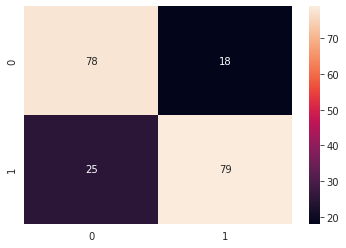

In [41]:
plot_confusion(y_test,model_0_predictions)

In [25]:
# creating random prediction
def random_prediction(predictions):
  i = random.randint(0,199)
  print('True label:'+str(y_test.iloc[i]))
  print(x_test.iloc[i])
  print('Predicted value:'+str(np.array(predictions)[i]))
  if int(np.array(predictions)[i])== int(y_test.iloc[i]):
    print('Model Predicted Correct')

  else:
    print('Model Wrongly Predicted')

In [73]:
random_prediction(model_0_predictions)

True label:1
I went to Bachi Burger on a friend's recommendation and was not disappointed.
Predicted value:0.0


### Model 1: Pretrained Feature Extractor (Universal Sentence Encoder)

In [26]:
# creating a model with tensorflow hub layer USE

import tensorflow_hub as hub

tf_hub_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable=False)

In [27]:
# constructing model

tf.keras.backend.clear_session()

inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding(inputs)

x = layers.Dense(128,activation='relu')(pretrained_embedding)

outputs = layers.Dense(1,activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs,outputs)

In [28]:
# compiling model
model_1.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [32]:
# creating early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',patience=5)

model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/data/Resturant_Reviews/models/model_1',monitor='val_accuracy',save_best_only=True,verbose=1)

In [33]:
# fitting the data into the model

model_1.fit(x=x_train,y=y_train,epochs=50,validation_data=(x_test,y_test),callbacks=[model_checkpoint])

Epoch 1/50
24/25 [===========================>..] - ETA: 0s - loss: 0.1587 - accuracy: 0.9414
Epoch 1: val_accuracy improved from -inf to 0.88000, saving model to /content/drive/MyDrive/data/Resturant_Reviews/models/model_1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/Resturant_Reviews/models/model_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/Resturant_Reviews/models/model_1/assets


25/25 [==============================] - 10s 412ms/step - loss: 0.1591 - accuracy: 0.9425 - val_loss: 0.2757 - val_accuracy: 0.8800
Epoch 2/50
23/25 [==========================>...] - ETA: 0s - loss: 0.1460 - accuracy: 0.9497
Epoch 2: val_accuracy improved from 0.88000 to 0.88500, saving model to /content/drive/MyDrive/data/Resturant_Reviews/models/model_1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/Resturant_Reviews/models/model_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/Resturant_Reviews/models/model_1/assets


25/25 [==============================] - 10s 401ms/step - loss: 0.1482 - accuracy: 0.9475 - val_loss: 0.2842 - val_accuracy: 0.8850
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9475
Epoch 3: val_accuracy did not improve from 0.88500
25/25 [==============================] - 1s 29ms/step - loss: 0.1395 - accuracy: 0.9475 - val_loss: 0.2859 - val_accuracy: 0.8800
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9525
Epoch 4: val_accuracy did not improve from 0.88500
25/25 [==============================] - 1s 44ms/step - loss: 0.1324 - accuracy: 0.9525 - val_loss: 0.2819 - val_accuracy: 0.8850
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9538
Epoch 5: val_accuracy did not improve from 0.88500
25/25 [==============================] - 1s 36ms/step - loss: 0.1259 - accuracy: 0.9538 - val_loss: 0.3062 - val_accuracy: 0.8750
Epoch 6/50
24/25 [=========================

In [34]:
# predictions
preds = model_1.predict(x_test)
model_1_predictions = tf.squeeze(tf.round(preds))
model_1_predictions

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.], dtype=float32)>

In [37]:
model_evaluation(y_test,model_1_predictions)

accuracy score:0.87
recall score:0.8653846153846154
precision score:0.8823529411764706
f1 score:0.8737864077669903


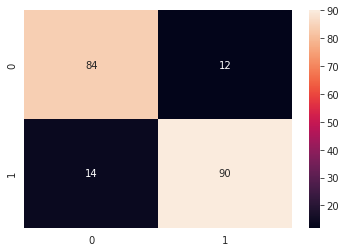

In [39]:
from sklearn.metrics import confusion_matrix

plot_confusion(y_test,model_1_predictions)

In [44]:
# random samples
random_prediction(model_1_predictions)

True label:1
Very friendly staff.
Predicted value:1.0
Model Predicted Correct


### Model 2: Bi-directional LSTM with Character Embeddings

In [29]:
# creating fxn to split into characters
def split_chars(text):
  return ' '.join(list(text))

In [30]:
train_chars =[]
for i in x_train:
  i=split_chars(i)
  train_chars.append(i)

In [31]:
train_chars[:5]

['T h e   w o r s t   w a s   t h e   s a l m o n   s a s h i m i .',
 'A n   e x c e l l e n t   n e w   r e s t a u r a n t   b y   a n   e x p e r i e n c e d   F r e n c h m a n .',
 'W e n t   f o r   l u n c h   -   s e r v i c e   w a s   s l o w .',
 'I   t h i n k   t h i s   r e s t a u r a n t   s u f f e r s   f r o m   n o t   t r y i n g   h a r d   e n o u g h .',
 'J u s t   h a d   l u n c h   h e r e   a n d   h a d   a   g r e a t   e x p e r i e n c e .']

In [32]:
# length of tokens which covers 95% data
np.percentile(length_sequence,95)

121.0

In [33]:
char_vectorizer = TextVectorization(max_tokens=120,output_sequence_length=50,standardize=None)
char_vectorizer.adapt(train_chars)

In [34]:
# creating an embedding layers
char_embedding = Embedding(input_dim=50,output_dim=24,mask_zero=False)

In [35]:
# constructing model
tf.keras.backend.clear_session()

inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vector = char_vectorizer(inputs)
char_embed = char_embedding(char_vector)

x = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(char_embed)
x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation = 'relu')(x)

outputs = layers.Dense(1,activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs,outputs)

In [36]:
# compiling the model
model_2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 50, 24)            1200      
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          156672    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 128)          164352    
 nal)                                                            
                                                             

In [66]:
# creating callbacks
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/data/Resturant_Reviews/models/model_2',monitor='val_accuracy',save_best_only=True,verbose=1)

In [74]:
# fitting the data into the model

model_2.fit(x=x_train,y=y_train,epochs=20,validation_data=(x_test,y_test))

Epoch 1/20
25/25 [==============================] - 7s 75ms/step - loss: 0.6924 - accuracy: 0.5125 - val_loss: 0.6892 - val_accuracy: 0.5250
Epoch 2/20
25/25 [==============================] - 0s 19ms/step - loss: 0.6919 - accuracy: 0.5475 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 3/20
25/25 [==============================] - 0s 19ms/step - loss: 0.6924 - accuracy: 0.5213 - val_loss: 0.6901 - val_accuracy: 0.5250
Epoch 4/20
25/25 [==============================] - 0s 19ms/step - loss: 0.6896 - accuracy: 0.5188 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 5/20
25/25 [==============================] - 0s 19ms/step - loss: 0.6903 - accuracy: 0.5350 - val_loss: 0.6867 - val_accuracy: 0.5350
Epoch 6/20
25/25 [==============================] - 0s 19ms/step - loss: 0.6874 - accuracy: 0.5525 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 7/20
25/25 [==============================] - 0s 19ms/step - loss: 0.6924 - accuracy: 0.5437 - val_loss: 0.6887 - val_accuracy: 0.5600
Epoch 8/20
25

In [83]:
preds = model_2.predict(x_test)
model_2_predictions = tf.squeeze(tf.round(preds))
model_2_predictions

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [84]:
# evaluating
model_evaluation(y_test,model_2_predictions)

accuracy score:0.555
recall score:0.8846153846153846
precision score:0.5443786982248521
f1 score:0.6739926739926739


### Model 3: Pretrained Feature Extraction and Conv1D with Token Embedding


1.   Create token level embedding for conv1d layer
2.   Create keras pretrained layer
3.   Combine 1 and 2 with `tf.layer.Concatenate`
4.   Bulid the otuput layer on the top of 3
5.   Construct the model and fit the data




In [37]:
# clearing the session
tf.keras.backend.clear_session()

#1. token embedding for conv1d
conv_inputs = layers.Input(shape=(1,),dtype=tf.string)
conv_token = text_vectorizer(conv_inputs)
conv_embed = token_embed(conv_token)

x = layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(conv_embed)
x = layers.GlobalAvgPool1D()(x)

conv_outputs = layers.Dense(32,activation='relu')(x)

# creating conv model
conv_model = tf.keras.Model(inputs=conv_inputs,outputs=conv_outputs)



#2. pretrained keras layer
pre_inputs = layers.Input(shape=[],dtype=tf.string)
y = tf_hub_embedding(pre_inputs)

pre_outputs = layers.Dense(128,activation='relu')(y)

#creating pre trained tensorflow hub model
pre_model = tf.keras.Model(inputs=pre_inputs,outputs=pre_outputs)


#3. combining both 1 and 2
conv_pre_concat = layers.Concatenate()([conv_model.output,pre_model.output])
z = layers.Dropout(0.5)(conv_pre_concat)


#4. creating an output layer
combined_dense = layers.Dense(32,activation='relu')(z)
combined_drop = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(1,activation='sigmoid')(combined_drop)


#5. creating a hybrid model
model_3 = tf.keras.Model(inputs=[conv_model.input,pre_model.input],outputs=output_layer)

#compiling the model
model_3.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

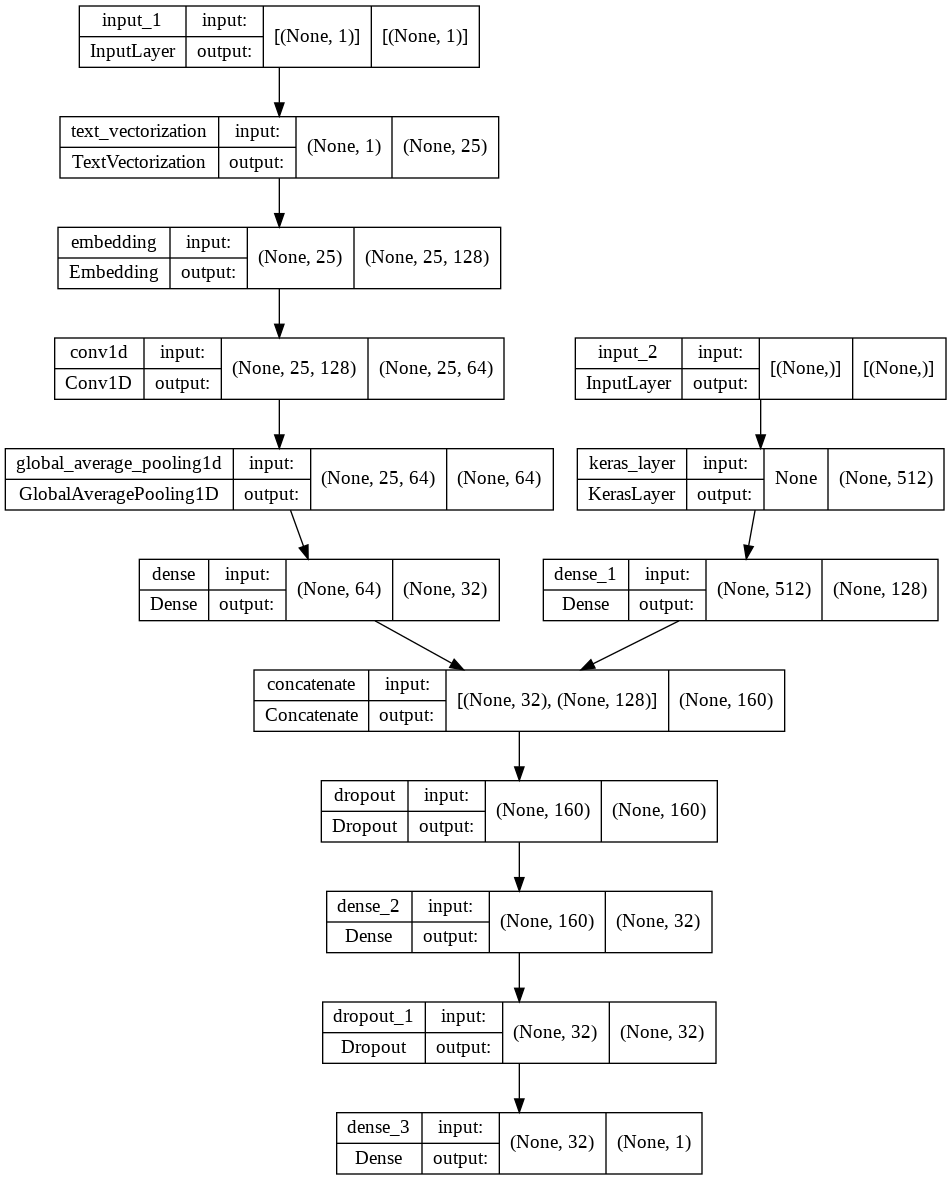

In [38]:
# plotting the model

tf.keras.utils.plot_model(model_3,show_shapes=True)

In [39]:
model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 25)          0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 25, 128)      396800      ['text_vectorization[1][0]']     
                                                                                                  
 conv1d (Conv1D)                (None, 25, 64)       41024       ['embedding[1][0]']        

In [42]:
# fitting the model
model_3.fit(x=[x_train,x_train],y=y_train,epochs=8,validation_data=([x_test,x_test],y_test))

Epoch 1/8
25/25 [==============================] - 4s 54ms/step - loss: 0.6838 - accuracy: 0.5700 - val_loss: 0.6586 - val_accuracy: 0.8150
Epoch 2/8
25/25 [==============================] - 1s 26ms/step - loss: 0.6041 - accuracy: 0.7975 - val_loss: 0.5402 - val_accuracy: 0.8500
Epoch 3/8
25/25 [==============================] - 1s 25ms/step - loss: 0.4412 - accuracy: 0.8750 - val_loss: 0.3870 - val_accuracy: 0.8350
Epoch 4/8
25/25 [==============================] - 1s 26ms/step - loss: 0.2773 - accuracy: 0.9013 - val_loss: 0.2925 - val_accuracy: 0.8800
Epoch 5/8
25/25 [==============================] - 1s 26ms/step - loss: 0.1567 - accuracy: 0.9538 - val_loss: 0.2809 - val_accuracy: 0.8850
Epoch 6/8
25/25 [==============================] - 1s 25ms/step - loss: 0.0766 - accuracy: 0.9812 - val_loss: 0.3301 - val_accuracy: 0.8900
Epoch 7/8
25/25 [==============================] - 1s 25ms/step - loss: 0.0465 - accuracy: 0.9875 - val_loss: 0.4542 - val_accuracy: 0.8650
Epoch 8/8
25/25 [===

In [44]:
#predictions
preds = model_3.predict([x_test,x_test])
model_3_predictions = tf.squeeze(tf.round(preds))

In [45]:
#evaluating the model
model_evaluation(y_test,model_3_predictions)

accuracy score:0.865
recall score:0.8076923076923077
precision score:0.9230769230769231
f1 score:0.8615384615384616


In [49]:
random_prediction(model_3_predictions)

True label:0
We won't be going back anytime soon!
Predicted value:0.0
Model Predicted Correct


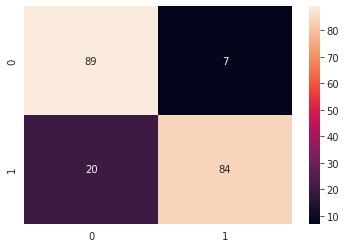

In [51]:
plot_confusion(y_test,model_3_predictions)

### Model 4: Pretained Tensorflow Hub (Fine Tuning)


1.   Create Feature Extraction Model (Same as Model 1)
2.   Train the output Layer
3.   Unfreeze the layers which train according with the output layer



In [51]:
#1. create feature extraction model
import tensorflow_hub as hub

tf_hub_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable=False)

In [44]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=[],dtype=tf.string)
keras_layer = tf_hub_embedding(inputs)

x = layers.Dense(128,activation='relu')(keras_layer)
outputs = layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs,outputs)

#compiling model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics= ['accuracy'])

#summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [45]:
#2. trainig the output layer
model.fit(x=x_train,y=y_train,epochs=8,validation_data=(x_test,y_test))

Epoch 1/8
25/25 [==============================] - 9s 55ms/step - loss: 0.6430 - accuracy: 0.7638 - val_loss: 0.5911 - val_accuracy: 0.8350
Epoch 2/8
25/25 [==============================] - 1s 21ms/step - loss: 0.4924 - accuracy: 0.8925 - val_loss: 0.4500 - val_accuracy: 0.8650
Epoch 3/8
25/25 [==============================] - 1s 23ms/step - loss: 0.3504 - accuracy: 0.9062 - val_loss: 0.3579 - val_accuracy: 0.8700
Epoch 4/8
25/25 [==============================] - 1s 22ms/step - loss: 0.2685 - accuracy: 0.9150 - val_loss: 0.3187 - val_accuracy: 0.8850
Epoch 5/8
25/25 [==============================] - 1s 22ms/step - loss: 0.2290 - accuracy: 0.9237 - val_loss: 0.2934 - val_accuracy: 0.9000
Epoch 6/8
25/25 [==============================] - 1s 22ms/step - loss: 0.2019 - accuracy: 0.9350 - val_loss: 0.2858 - val_accuracy: 0.9050
Epoch 7/8
25/25 [==============================] - 1s 23ms/step - loss: 0.1842 - accuracy: 0.9388 - val_loss: 0.2790 - val_accuracy: 0.8950
Epoch 8/8
25/25 [===

In [49]:
#3. unfreezing the layer to train and fine tune the model
tf_hub_embedding.trainable=True

# compiling the model after making changes in model
model.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

#summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 256,863,617
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(x=x_train,y=y_train,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
25/25 [==============================] - 4s 169ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2675 - val_accuracy: 0.8900
Epoch 2/10
25/25 [==============================] - 4s 153ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2832 - val_accuracy: 0.8950
Epoch 3/10
25/25 [==============================] - 4s 154ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3062 - val_accuracy: 0.8950
Epoch 4/10
25/25 [==============================] - 4s 153ms/step - loss: 7.9246e-04 - accuracy: 1.0000 - val_loss: 0.3206 - val_accuracy: 0.9000
Epoch 5/10
25/25 [==============================] - 4s 158ms/step - loss: 6.0170e-04 - accuracy: 1.0000 - val_loss: 0.3277 - val_accuracy: 0.8950
Epoch 6/10
25/25 [==============================] - 4s 160ms/step - loss: 4.6022e-04 - accuracy: 1.0000 - val_loss: 0.3574 - val_accuracy: 0.8900
Epoch 7/10
25/25 [==============================] - 4s 159ms/step - loss: 3.5917e-04 - accuracy: 1.0000 - val_loss: 0.3261 - val_accurac

In [52]:
preds = model.predict(x_test)
model_4_predictions = tf.squeeze(tf.round(preds))

In [53]:
# evaluation
model_evaluation(y_test,model_4_predictions)

accuracy score:0.895
recall score:0.8365384615384616
precision score:0.9560439560439561
f1 score:0.8923076923076924


###Comparing all Model's Performance

In [56]:
performance = pd.DataFrame(data=[[0.785,0.7596153846153846,0.8144329896907216,0.7860696517412934],
                                 [0.87,0.8653846153846154,0.8823529411764706,0.8737864077669903],
                                 [0.555,0.8846153846153846,0.5443786982248521,0.6739926739926739],
                                 [0.865,0.8076923076923077,0.9230769230769231,0.8615384615384616],
                                 [0.895,0.8365384615384616,0.9560439560439561,0.8923076923076924]],
                           index=['Model0','Model1','Model2','Model3','Model4'],
                           columns=['accuracy','recall','precision','f1'])
performance

,accuracy,recall,precision,f1
Model0,0.785,0.759615,0.814433,0.786070
Model1,0.870,0.865385,0.882353,0.873786
Model2,0.555,0.884615,0.544379,0.673993
Model3,0.865,0.807692,0.923077,0.861538
Model4,0.895,0.836538,0.956044,0.892308


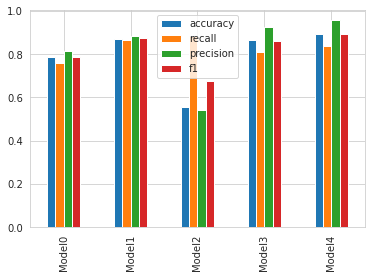

In [69]:
#ploting the graph of the model's evaluation
performance.plot(kind='bar')

### Conclusion:
From all the above runned experiments `Model 4: Pretrained Tensorflow Hub (Fine Tuning)` predicts the labels of the reviews with maximum correctness, having the greatest accuracy among all of the model.

Models are ranked according to thier performance


1.   Model 4: Pretained Tensorflow Hub (Fine Tuning)
2.   Model 1: Pretrained Feature Extractor (Universal Sentence Encoder)
3.   Model 3: Pretrained Feature Extraction and Conv1D with Token    Embedding
4.   Model 0 : Conv1D using Functional API
5.   Model 2: Bi-directional LSTM with Character Embeddings
